In [26]:
# !pip install seqeval

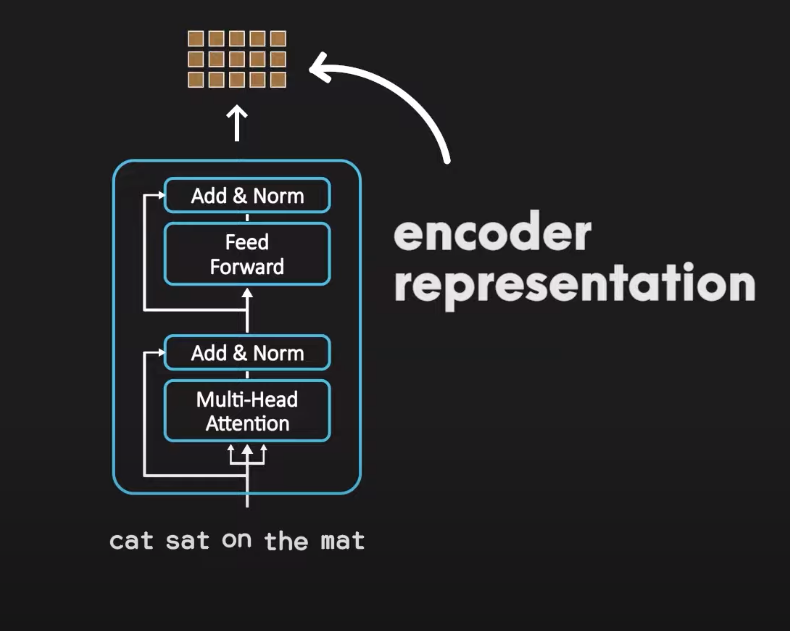

In [27]:
from IPython import display
display.Image("./transformer.png")

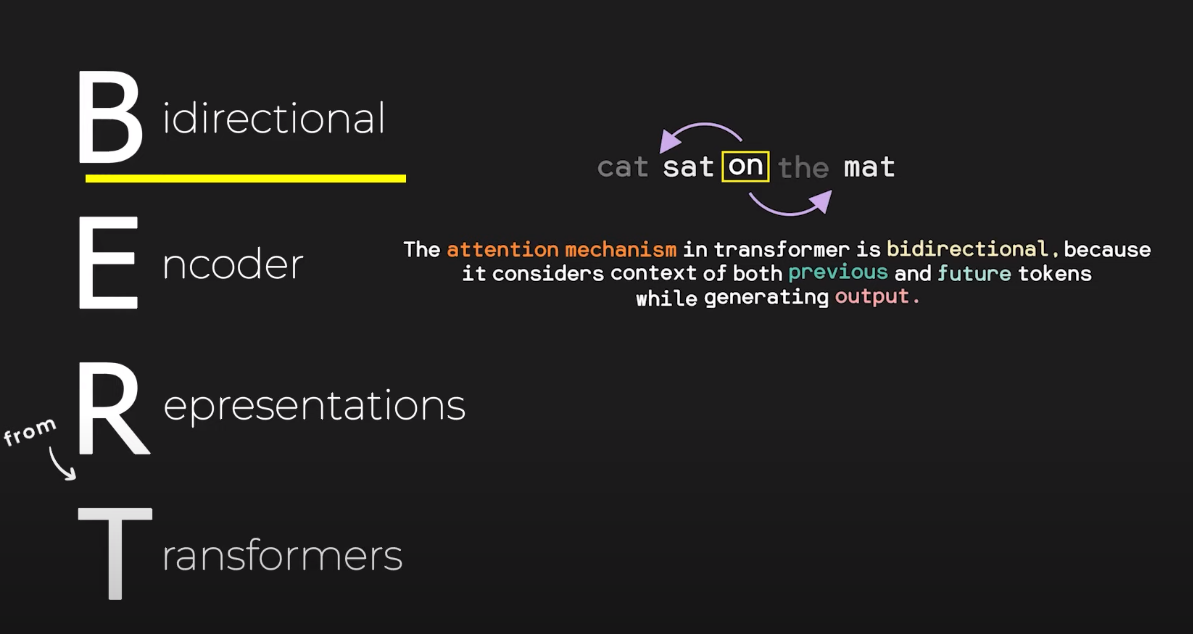

In [28]:
display.Image("./BERT.png")

In [29]:
import pandas as pd
import re
from transformers import AutoTokenizer
from datasets import Dataset, Features, Value, ClassLabel, Sequence
from seqeval.metrics import accuracy_score
# from seqeval.metrics import classification_report
# from seqeval.metrics import precision_score

In [30]:
df = pd.read_csv('../datasets/mtsamples.csv')
df.head()

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


### Required Functions

In [31]:
def get_transcription_types():
    sub_ls = []
    for ts in df['transcription']:
        data = get_initials(ts)
        if data is not None:
            sub_ls.append(data)


    unique_sub_ls = tuple()
    for sub in sub_ls:
        if unique_sub_ls.count(sub) == 0:
            unique_sub_ls = unique_sub_ls + (sub,)

    return sorted(unique_sub_ls)


def get_initials(data):
    data = str(data)
    subject = ''
    subject = data.split(',')
    if len(subject[0]) < 50:
        subject[0] = subject[0].strip()
        words = subject[0].split(' ')
        if words[0] == words[0].upper():
            if subject[0][-1] == ':':
                subject[0] = subject[0][:-1]
                return subject[0]
    

def get_tokens_with_entities(raw_text: str):
    # split the text by spaces only if the space does not occur between square brackets
    # we do not want to split "multi-word" entity value yet
    raw_tokens = re.split(r"\s(?![^\[]*\])", raw_text)

    # a regex for matching the annotation according to our notation [entity_value](entity_name)
    entity_value_pattern = r"\[(?P<value>.+?)\]\((?P<entity>.+?)\)"
    entity_value_pattern_compiled = re.compile(entity_value_pattern, flags=re.I|re.M)

    tokens_with_entities = []

    for raw_token in raw_tokens:
        match = entity_value_pattern_compiled.match(raw_token)
        if match:
            raw_entity_name, raw_entity_value = match.group("entity"), match.group("value")

            # we prefix the name of entity differently
            # B- indicates beginning of an entity
            # I- indicates the token is not a new entity itself but rather a part of existing one
            for i, raw_entity_token in enumerate(re.split("\s", raw_entity_value)):
                entity_prefix = "B" if i == 0 else "I"
                entity_name = f"{entity_prefix}-{raw_entity_name}"
                tokens_with_entities.append((raw_entity_token, entity_name))
        else:
            tokens_with_entities.append((raw_token, "O"))

    return tokens_with_entities

def remove_symptom_notation(text):
    # Remove [symptom] notation
    text = re.sub(r'\[(.*?)\]', r'\1', text)
    # Remove (symptom) notation
    text = re.sub(r'\((.*?)\)', r'\1', text)
    # Remove the word "symptom"
    text = text.replace('symptom', '')
    if not text[-1].isalpha(): text = text[:-1]
    return text

def set_token_entities(text, predicted_text):
    
    symptom_pos = []
    for entity in predicted_text:
        symptom_pos.append((entity['start'], entity['end']))
    
    entity_set = []
    done = []
    
    for coord in symptom_pos:
        extracted_text = text[coord[0]: coord[1]]
        
        words = extracted_text.split(' ')
        if len(words) == 1:
            entity_set.append((words[0], 'B-symptom'))
            done.append(words[0])
        else:
            for i in range(len(words)):
                if i == 0: 
                    entity_set.append((words[i], 'B-symptom'))
                else:
                    entity_set.append((words[i], 'I-symptom'))
                done.append(words[i])
                
    words = text.split(' ')
    for i in range(len(words)):
        if words[i] not in done:
            entity_set.append((words[i], 'O'))
            
    # reorder list 
    final_output = []
    for word in words:
        for item in entity_set:
            if word == item[0]:
                final_output.append(item)
                break
    
    return final_output

def evaluate(y_true, y_pred, verbose):
    
    a = []
    b = []
    for tple in y_true:
        a.append(tple[1])
        
    for tple in y_pred:
        b.append(tple[1])
    
    if verbose:
        print("Accuracy: ", round(accuracy_score([a], [b]), 2))
        print("===\n")
        
    return round(accuracy_score([a], [b]), 2)
    
    
print('done')

done


### Exploring the Dataset
**It's necessary as we want to find out the appropiate data points that are suitable to train our model**

In [32]:
# finding the counts of each of transcription types
ts_type = get_transcription_types()
ts_type_count = {}

for item in ts_type:
    ts_type_count[item] = 0
        
for idx, ndf in df.iterrows():
    data = ndf['transcription']
    initial = get_initials(data)
    if initial is not None:
        ts_type_count[str(initial)] += 1

sorted_ts_count = dict(sorted(ts_type_count.items(), key=lambda item: item[0], reverse=False))
# for ts, cnt in sorted_ts_count.items():
#     print(ts, cnt)

In [33]:
with open('complain.txt', 'w+') as f:
    # save only the subjective transciptions
    for idx, ndf in df.iterrows():
        data = ndf['transcription']
        initial = get_initials(data)
        if initial == 'SUBJECTIVE':
            transcript = ndf['transcription']
            parts = transcript.split(':,')
#             print(transcript)
            f.write(transcript)
            f.write('\n\n')

#             print('>>', end=' ')
#             print(ndf['keywords'])
#             print('--\n')
            
    f.close

### Dataset Maker Function for Training with Transformers

In [34]:
class NERDataMaker:
    def __init__(self, texts):
        self.unique_entities = []
        self.processed_texts = []

        temp_processed_texts = []
        for text in texts:
            tokens_with_entities = get_tokens_with_entities(text)
            for _, ent in tokens_with_entities:
                if ent not in self.unique_entities:
                    self.unique_entities.append(ent)
            temp_processed_texts.append(tokens_with_entities)

        self.unique_entities.sort(key=lambda ent: ent if ent != "O" else "")

        for tokens_with_entities in temp_processed_texts:
            self.processed_texts.append([(t, self.unique_entities.index(ent)) for t, ent in tokens_with_entities])

    @property
    def id2label(self):
        return dict(enumerate(self.unique_entities))

    @property
    def label2id(self):
        return {v:k for k, v in self.id2label.items()}

    def __len__(self):
        return len(self.processed_texts)

    def __getitem__(self, idx):
        def _process_tokens_for_one_text(id, tokens_with_encoded_entities):
            ner_tags = []
            tokens = []
            for t, ent in tokens_with_encoded_entities:
                ner_tags.append(ent)
                tokens.append(t)

            return {
                "id": id,
                "ner_tags": ner_tags,
                "tokens": tokens
            }

        tokens_with_encoded_entities = self.processed_texts[idx]
        if isinstance(idx, int):
            return _process_tokens_for_one_text(idx, tokens_with_encoded_entities)
        else:
            return [_process_tokens_for_one_text(i+idx.start, tee) for i, tee in enumerate(tokens_with_encoded_entities)]

    def as_hf_dataset(self, tokenizer):
        
        def tokenize_and_align_labels(examples):
            tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

            labels = []
            for i, label in enumerate(examples[f"ner_tags"]):
                word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
                previous_word_idx = None
                label_ids = []
                for word_idx in word_ids:  # Set the special tokens to -100.
                    if word_idx is None:
                        label_ids.append(-100)
                    elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                        label_ids.append(label[word_idx])
                    else:
                        label_ids.append(-100)
                    previous_word_idx = word_idx
                labels.append(label_ids)

            tokenized_inputs["labels"] = labels
            return tokenized_inputs

        ids, ner_tags, tokens = [], [], []
        for i, pt in enumerate(self.processed_texts):
            ids.append(i)
            pt_tokens,pt_tags = list(zip(*pt))
            ner_tags.append(pt_tags)
            tokens.append(pt_tokens)
        data = {
            "id": ids,
            "ner_tags": ner_tags,
            "tokens": tokens
        }
        features = Features({
            "tokens": Sequence(Value("string")),
            "ner_tags": Sequence(ClassLabel(names=self.unique_entities)),
            "id": Value("int32")
        })
        print("Features: ", features)
        ds = Dataset.from_dict(data, features)
        tokenized_ds = ds.map(tokenize_and_align_labels, batched=True)
        return tokenized_ds
    
print('done')

done


### Reading Data 

In [35]:
data = ""
with open('../datasets/annotated.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        data += line

In [36]:
import random

temp = """1. This 35-year-old male patient comes in with complaints of [headache](symptom) and [nausea](symptom) after a recent head injury.
2. A 28-year-old female reports [shortness of breath](symptom), [chest pain](symptom), and [palpitations](symptom) during physical activity.
3. The 42-year-old patient describes [fever](symptom), [cough](symptom), and [fatigue](symptom) as their main symptoms.
4. This 19-year-old student presents with [fever](symptom), [sore throat](symptom), and [loss of taste and smell](symptom) for the past few days.
5. A 50-year-old male patient experiences [joint pain](symptom), [muscle weakness](symptom), and [fatigue](symptom).
6. The 31-year-old athlete complains of [knee pain](symptom), [swelling](symptom), and [limited range of motion](symptom) after a sports injury.
7. This 60-year-old woman reports [back pain](symptom), [numbness in legs](symptom), and [weakness](symptom) in her lower limbs.
8. A 25-year-old individual presents with [abdominal pain](symptom), [bloating](symptom), and [constipation](symptom).
9. The 48-year-old patient describes [vision problems](symptom), [headache](symptom), and [dizziness](symptom) for the past week.
10. This 22-year-old male reports [skin rash](symptom), [itching](symptom), and [redness](symptom) on various parts of the body."""

lines = data.strip().split('\n')
random.shuffle(lines)
print(len(lines))

train_ratio = 0.8  # 80% for training, 20% for testing

# Calculate the split point based on the ratio
split_point = int(len(lines) * train_ratio)

train_lines = lines[:split_point]
test_lines = lines[split_point:]

train_text = '\n'.join(train_lines)
test_text = '\n'.join(test_lines)

train_dm = NERDataMaker(train_text.split('\n'))
test_dm = NERDataMaker(test_text.split('\n'))

print(len(train_dm), len(test_dm))
train_dm[1]

275
220 55


{'id': 1,
 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 1, 0, 0, 0],
 'tokens': ['The',
  '79-year-old',
  'African-American',
  'female',
  'with',
  'a',
  'history',
  'of',
  'type',
  '2',
  'diabetes',
  'reports',
  'no',
  'allergies',
  'to',
  'any',
  'medicines.']}

In [37]:
from transformers import AutoTokenizer, DataCollatorForTokenClassification, AutoModelForTokenClassification, TrainingArguments, Trainer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

print(train_dm.unique_entities)

model = AutoModelForTokenClassification.from_pretrained("distilbert-base-uncased", num_labels=len(train_dm.unique_entities), id2label=train_dm.id2label, label2id=train_dm.label2id)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,             # keep it 2e-5
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=11,           # 11 epoch gives optimal validation loss
    weight_decay=0.01,
)

train_ds = train_dm.as_hf_dataset(tokenizer=tokenizer)
test_ds = test_dm.as_hf_dataset(tokenizer=tokenizer)

print(train_ds[0])

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds, # eval on training set! ONLY for DEMO!! have to split the data into train test split
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

['O', 'B-symptom', 'I-symptom']


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Features:  {'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-symptom', 'I-symptom'], id=None), length=-1, id=None), 'id': Value(dtype='int32', id=None)}


Map: 100%|██████████| 220/220 [00:00<00:00, 5487.97 examples/s]


Features:  {'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-symptom', 'I-symptom'], id=None), length=-1, id=None), 'id': Value(dtype='int32', id=None)}


Map: 100%|██████████| 55/55 [00:00<00:00, 4177.67 examples/s]


{'id': 0, 'ner_tags': [0, 0, 0, 1, 2, 1, 2, 0, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0], 'tokens': ['He', 'also', 'experiences', 'loose', 'stools', 'intermittent', 'nausea', 'and', 'funny', 'green', 'color', 'in', 'bowel', 'movements', 'over', 'the', 'last', 'three', 'days.'], 'input_ids': [101, 2002, 2036, 6322, 6065, 14708, 2015, 23852, 19029, 1998, 6057, 2665, 3609, 1999, 6812, 2884, 5750, 2058, 1996, 2197, 2093, 2420, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 0, 0, 0, 1, 2, -100, 1, 2, 0, 1, 2, 2, 2, 2, -100, 2, 0, 0, 0, 0, 0, -100, -100]}


  9%|▉         | 14/154 [00:34<04:12,  1.80s/it]

{'eval_loss': 0.611436665058136, 'eval_runtime': 1.3379, 'eval_samples_per_second': 41.109, 'eval_steps_per_second': 2.99, 'epoch': 1.0}


 18%|█▊        | 28/154 [01:06<04:48,  2.29s/it]

{'eval_loss': 0.4518047273159027, 'eval_runtime': 1.9277, 'eval_samples_per_second': 28.532, 'eval_steps_per_second': 2.075, 'epoch': 2.0}


 27%|██▋       | 42/154 [01:37<03:57,  2.12s/it]

{'eval_loss': 0.4001951515674591, 'eval_runtime': 1.6423, 'eval_samples_per_second': 33.489, 'eval_steps_per_second': 2.436, 'epoch': 3.0}


 36%|███▋      | 56/154 [02:04<02:47,  1.70s/it]

{'eval_loss': 0.3642624020576477, 'eval_runtime': 1.1476, 'eval_samples_per_second': 47.926, 'eval_steps_per_second': 3.486, 'epoch': 4.0}


 45%|████▌     | 70/154 [02:28<02:15,  1.61s/it]

{'eval_loss': 0.32182565331459045, 'eval_runtime': 1.1215, 'eval_samples_per_second': 49.04, 'eval_steps_per_second': 3.567, 'epoch': 5.0}


 55%|█████▍    | 84/154 [02:49<01:32,  1.32s/it]

{'eval_loss': 0.29931116104125977, 'eval_runtime': 1.2002, 'eval_samples_per_second': 45.824, 'eval_steps_per_second': 3.333, 'epoch': 6.0}


 64%|██████▎   | 98/154 [03:12<01:18,  1.39s/it]

{'eval_loss': 0.30192098021507263, 'eval_runtime': 1.0394, 'eval_samples_per_second': 52.913, 'eval_steps_per_second': 3.848, 'epoch': 7.0}


 73%|███████▎  | 112/154 [03:35<01:02,  1.49s/it]

{'eval_loss': 0.28458350896835327, 'eval_runtime': 1.452, 'eval_samples_per_second': 37.879, 'eval_steps_per_second': 2.755, 'epoch': 8.0}


 82%|████████▏ | 126/154 [03:58<00:40,  1.46s/it]

{'eval_loss': 0.2905144989490509, 'eval_runtime': 1.1587, 'eval_samples_per_second': 47.465, 'eval_steps_per_second': 3.452, 'epoch': 9.0}


 91%|█████████ | 140/154 [04:23<00:20,  1.45s/it]

{'eval_loss': 0.2871520519256592, 'eval_runtime': 1.3184, 'eval_samples_per_second': 41.716, 'eval_steps_per_second': 3.034, 'epoch': 10.0}


100%|██████████| 154/154 [04:47<00:00,  1.86s/it]

{'eval_loss': 0.2892133593559265, 'eval_runtime': 1.0523, 'eval_samples_per_second': 52.268, 'eval_steps_per_second': 3.801, 'epoch': 11.0}
{'train_runtime': 287.1552, 'train_samples_per_second': 8.427, 'train_steps_per_second': 0.536, 'train_loss': 0.29048352427296825, 'epoch': 11.0}


TrainOutput(global_step=154, training_loss=0.29048352427296825, metrics={'train_runtime': 287.1552, 'train_samples_per_second': 8.427, 'train_steps_per_second': 0.536, 'train_loss': 0.29048352427296825, 'epoch': 11.0})

**Issue is the valuation loss became very high at the current tuned model, We have to tune further**

In [38]:
model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")

('./fine_tuned_model/tokenizer_config.json',
 './fine_tuned_model/special_tokens_map.json',
 './fine_tuned_model/vocab.txt',
 './fine_tuned_model/added_tokens.json',
 './fine_tuned_model/tokenizer.json')

In [39]:
from datasets import load_metric
metric = load_metric("accuracy")

# Evaluate the model on the test dataset
results = trainer.evaluate()

# Calculate accuracy
accuracy = results
print(f"Validation Loss: {round(accuracy['eval_loss'], 3)}")

100%|██████████| 4/4 [00:00<00:00,  6.18it/s]

Validation Loss: 0.289


In [40]:
# Evaluating the model
from transformers import pipeline

pipe = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple") # pass device=0 if using gpu

test_data = test_text.split('\n')
avg_acc = []
for data in test_data:
    
    y_true = get_tokens_with_entities(data)
    
    data = remove_symptom_notation(data)
    predicted_text = pipe(data)
    
    y_pred = set_token_entities(data, predicted_text)
    
    avg_acc.append(evaluate(y_true, y_pred, False))
    
print("Average Accuracy: ", round(sum(avg_acc)/len(avg_acc), 3)*100, '%')

Average Accuracy:  81.5 %


In [41]:
from transformers import pipeline

pipe = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple") # pass device=0 if using gpu
data = '''
The common symptoms of diabetes include increased thirst and hunger, frequent urination, fatigue, blurred vision, slow-healing wounds, and numbness or tingling in the hands and feet
'''

data = remove_symptom_notation(data)
predicted_text = pipe(data)
for i in range(len(predicted_text)):
    print('Symptom: ', predicted_text[i]['word'])

Symptom:  thirst and hunger
Symptom:  frequent urination
Symptom:  fatigue
Symptom:  blurred vision
Symptom:  slow
Symptom:  healing wounds
Symptom:  numbness or
Symptom:  tingling in the hands and feet
